In [1]:
import symd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pickle
import pandas as pd
import seaborn as sns

In [2]:
base_colors = ["f94144","f3722c","f8961e","f9844a","f9c74f","90be6d","43aa8b","4d908e","577590","277da1"]    
colors = ['#' + c for c in base_colors]
sns.set_style("white")
sns.set_style("ticks")
sns.set(rc={'axes.facecolor':'#f5f4e9', 
            'grid.color' : '#AAAAAA', 
            'axes.edgecolor':'#333333', 
            'figure.facecolor':'#FFFFFF', 
            'axes.grid': False,
            'axes.prop_cycle':   plt.cycler('color', plt.cm.Dark2.colors),
            'font.family': 'monospace'
           })
print(symd.__version__)

0.2.1


In [3]:
#!pip install seaborn pandas matplotlib

In [4]:
def run_sim(n, cell, group, w=None, retries=5, pos_frames=0):
    for _ in range(retries):
        try:
            md = symd.Symd(nparticles=n, cell=cell, ndims=2, images=2, force='lj', wyckoffs=w,
              group=group, steps=30000, exeDir='sim', start_temperature=0.5)
            md.remove_overlap()
            md.shrink()
            if pos_frames > 0:
                md.log_positions(frames=pos_frames)
            md.log_output(period = int(1 / md.runParams['time_step']))
            md.run()
            break
        except RuntimeError as e:
            print(e)
            md = None
    return md

In [5]:
np.random.seed(0)
md = run_sim(5, [20, 20], 17, pos_frames=100)

Shrunk from 1385.64 to 1028.87
New cell: [17.5083, 0.0, 0.0, 16.7119]


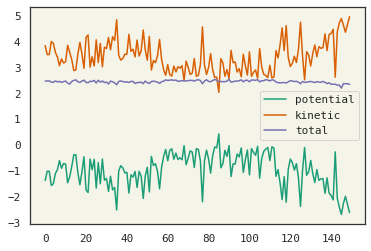

In [6]:
plt.plot(md.pe, label='potential')
plt.plot(md.ke, label='kinetic')
plt.plot(md.te, label='total')
plt.legend(loc='best')

## All Sims

In [7]:
titles = ['p1', 'p2', 'pm', 'pg', 'cm', 'pmm', 'pmg', 'pgg', 'cmm', 'p4', 'p4m', 'p4g', 'p3', 'p3m1', 'p31m', 'p6', 'p6m']
df = pd.DataFrame()
retries = 3
def smooth(x):
    window = int(np.ceil(len(x) / 10.0))
    weights = np.ones(window)
    energy_smooth = np.convolve(
        weights / weights.sum(), x[(window + 1):], mode="valid"
    )
    return x

def standardize(te):
    i = int(md.te.shape[0] * 0.2)
    te = md.te[i:]
    return te - np.mean(te)

In [8]:
for i,t in enumerate(titles):    
    md = run_sim(4, [20, 20], i+1)
    df = df.assign(**{t: standardize(md.te)})    

Shrunk from 400.268 to 362.49
New cell: [18.6532, 0.0, 0.0, 19.3407]
Shrunk from 400.268 to 362.49
New cell: [18.6532, 0.0, 0.0, 19.3407]
Shrunk from 400.268 to 363.277
New cell: [18.7116, 0.0, 0.0, 19.3231]
Shrunk from 400.268 to 362.49
New cell: [18.6532, 0.0, 0.0, 19.3407]
Shrunk from 400.268 to 362.748
New cell: [18.6347, 0.0, 0.0, 19.3571]
{"steps": 1000, "n_particles": 4, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "sim/group-6.dat", "cell_log_file": "sim/cell_log_file.dat", "print_period": 300.0, "cell": [20.0, 0.0, 0.0, 20.0], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "sim/group-6.dat", "group": "sim/group-6.json"}
Info: You are running version 9075-dirty of symd
Assuming you'll pass par

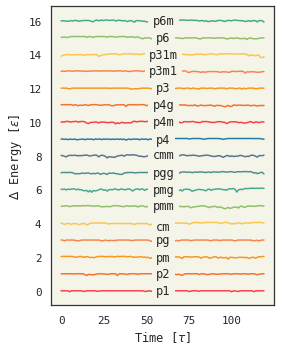

In [15]:
fig = plt.figure(figsize=(4,5.5))
ax = plt.gca()
mx = df.shape[0] // 2
for i,n in enumerate(df.columns):
    color = colors[i % len(base_colors)]
    ax.plot(df[n] + i, color=color)
    offsetbox = mpl.offsetbox.TextArea(n)
    #mx = (df.shape[0] - 1) * (i / df.shape[1])
    #if i % 2 == 0:
    #    mx = df.shape[0] - mx - 1
    ab = mpl.offsetbox.AnnotationBbox(offsetbox, (mx,df[n][mx] + i),
                    xybox=(mx,df[n][mx] + i),
                    xycoords='data',
                    boxcoords='data',
                    arrowprops=None,
                    bboxprops=dict(fc="#f5f4e9", lw=0))
    ax.add_artist(ab)
ax.set_xlabel(r'Time [$\tau$]')
ax.set_facecolor('#f5f4e9')
ax.set_ylabel(r'$\Delta$ Energy [$\epsilon$]')
plt.savefig('energy.pdf',  bbox_inches='tight')

## Atlas

In [10]:
def scale(x, ib):
    s = np.apply_along_axis(lambda xi: ib @ xi, 1, x)
    return np.fmod(s, 1.0)

def compute_symm(positions, gnum, cell, ndim, n):
    group = symd.groups.load_group(gnum, ndim)
    cell = np.array(cell).reshape(ndim,ndim)
    ib = np.linalg.inv(cell)
    s = scale(positions[:,:ndim], ib)    
    members = [symd.groups.str2mat(e) for e in group['genpos']]
    folded_positions = np.zeros_like(s)
    for i in range(n):
        folded_positions[i,:] = s[i,:]
        for j in range(1, len(members)):
            k = j * n + i
            im = np.linalg.inv(members[j])
            w = im[:ndim, :ndim]            
            folded_positions[i,:] += w @ s[k] + im[ndim, :ndim]
        folded_positions[i, :] /= len(members)
        for j in range(1, len(members)):
            k = j * n + i
            w = members[j][:ndim, :ndim]            
            folded_positions[k] = w @ folded_positions[i] + members[j][ndim, :ndim]    
    return np.mean((s[:k] - folded_positions[:k])**2)
def rmsd(p1, p2):
    return np.mean((p1 - p2)**2, axis=(1,2))

In [11]:
def crystal(n, cell, group, w=None, retries=2, steps=10**6, ndims=2):
    # adjust for group size
    m = len(symd.groups.load_group(group, ndims)['genpos'])
    n = max(2, n // m)
    if w is not None:
        n += sum(w)
        name = f'{group}-{n}-{sum(w)}'
    else:
        name = f'{group}-{n}'
    print('Simulating', n, 'particles:',name)    
    # break out the try/except because we will accept failed NPT (because it jams so hard)
    for i in range(retries):
        # NPT
        md = symd.Symd(nparticles=n, cell=cell, ndims=ndims, images=2, force='lj', wyckoffs=w,
          group=group, steps=steps, exeDir=f'crystal-{name}', pressure=0.5, temperature=0.1, start_temperature=0.5)
        try:        
            md.remove_overlap()
            md.shrink()
        except RuntimeError as e:
            continue
        md.log_positions()
        try:
            md.run()
        except RuntimeError as e:
            pass

        # NVT
        md.runParams['temperature'] = 0.05
        md.runParams['Pressure'] = None
        md.runParams['box_update_period'] = 0
        md.runParams['steps'] = steps // 10
        md.log_positions(filename='equil.xyz')
        try:
            md.run()
        except RuntimeError as e:
            continue
        config = md.positions[-1]

        # Stability
        fp = np.loadtxt(md.runParams['final_positions'])
        # changing group, so need to read normed cell
        cell = md.read_cell(normed=True)
        m = fp.shape[0]
        md2 = symd.Symd(nparticles=m, cell=cell, ndims=2, images=2, force='lj', wyckoffs=None,
          group=1, steps=5000, exeDir=f'melt-{name}', temperature=None, start_temperature=0)
        # run once to get melting traj
        # then again for longer with longer period
        md2.log_positions(period=5)
        md2.runParams['start_positions'] = md.runParams['final_positions']            
        try:
            md2.run()
        except RuntimeError as e:
            continue
        traj = md2.positions
        md2.runParams['steps'] = steps // 10
        md2.log_positions(period=int(1 / md2.runParams['time_step']))
        #md2.run()
        csm = rmsd(md2.positions[:,:m], md2.positions[0,:m])
        #csm = []
        #for i in range(md2.positions.shape[0]):
        #    csm.append(compute_symm(md2.positions[i], group, md2.read_cell(), ndims, n))
        return config, md2.positions[-1], csm, traj, np.arange(0,5000,5) * md2.runParams['time_step']
    return None

In [14]:
config, config2, csm, traj, time = crystal(8, [25, 25], 2, w=[1]*2)

Simulating 6 particles: 2-6-2
Shrunk from 624.675 to 624.675
New cell: [22.7857, 0.0, 0.0, 22.6886]


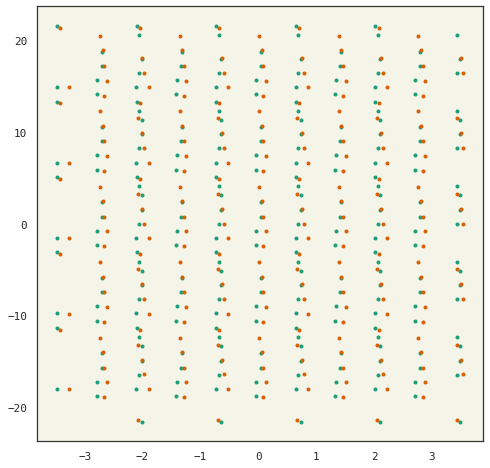

In [16]:
plt.figure(figsize=(8, 8))
plt.plot(config[:,0], config[:,1], '.')
plt.plot(config2[:,0], config2[:,1], '.')

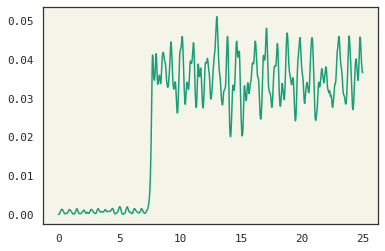

In [17]:
plt.plot(time, csm)

In [ ]:
from multiprocessing import Pool

cdf = None
results = []
trajs = {}

with Pool(8) as pool:
    for N in [8,16,32,128]:
        for i,t in enumerate(titles):
            W = len(symd.groups.load_group(i+1, 2)['specpos'])    
            for j in range(1 + W):
                wycks = None if j == 0 else [1] * j
                name = f'{t}-w{j}-n{N}'
                job = pool.apply_async(crystal, (N, [25, 25], i+1, wycks))
                #job = crystal(N, [25, 25], i+1, wycks)
                results.append((t, name, N, j, job))
                
    for r in results:        
        t, name, N, j, ar = r
        print('Getting result for ', name)
        res = ar.get()
        #res = ar
        if res is None:
            continue
        config, config2, csm, traj, time = res
        T = len(csm)
        
        df2 = pd.DataFrame({'Group':[t] * T, 'Traj': [name] * T, 
                            'N':[N] * T, 'Wyckoffs':[str(j)] * T, 'RMSD':csm, 'Time':time})
        if cdf is None:
            cdf = df2
        else:
            cdf = pd.concat((cdf, df2))
        trajs[name] = traj

SimulatingSimulatingSimulatingSimulatingSimulating  SimulatingSimulating   84Simulating  657   84   particles:particles:5 particles:particles: particles: particles: particles:  2-41-8  particles:2-6-2 2-5-1 2-7-3 
2-8-4
3-4


3-5-1


Getting result for  p1-w0-n8
Shrunk from 625.419 to 625.419Shrunk from 625.419 to 625.419

New cell: [22.7596, 0.0, 0.0, 23.3852]New cell: [22.7596, 0.0, 0.0, 23.3852]

Shrunk from 625.592 to 625.592
New cell: [22.9226, 0.0, 0.0, 21.8353]
Shrunk from 625.592 to 625.592
Shrunk from 624.675 to 624.675
New cell: [22.9442, 0.0, 0.0, 21.8646]
New cell: [22.7857, 0.0, 0.0, 22.7058]
Shrunk from 624.859 to 624.859
New cell: [22.6442, 0.0, 0.0, 23.0585]
Shrunk from 625.262 to 625.262
New cell: [23.4162, 0.0, 0.0, 23.1856]
Shrunk from 624.859 to 624.859
New cell: [22.6767, 0.0, 0.0, 23.1129]
{"steps": 5000, "n_particles": 8, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin":

In [ ]:
cdf.reset_index(inplace=True)
cdf.to_pickle('atlas2d.pkl.gz')
with open('atlast.2d.pkl', 'wb') as f:
    pickle.dump(trajs, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
sns.relplot(data=cdf, x='Time', y='RMSD', 
        kind='line', hue='Wyckoffs', col='Group', col_wrap=4,
        aspect=1, linewidth=1, ci=None, height=1.75, palette='Dark2')
plt.savefig('atlas_grid.pdf',  bbox_inches='tight')

## Movie

In [ ]:
# make a movie
import moviepy.editor as editor
from moviepy.video.io.bindings import mplfig_to_npimage


def plot(traj, title='@_172135352171_', color='#333333', fps=60):
    T, N, D = traj.shape    
    fps = fps
    duration = T / fps
    dpi = 90
    fig, ax = plt.subplots(figsize=(1200 / dpi, 800 / dpi), dpi=dpi)    
    points = ax.plot(traj[0,:,0], traj[0,:,1], color=color, marker='o', markeredgewidth=0.0, linestyle='None', alpha=1.0)[0]
    ax.set_facecolor('#f5f4e9')
    fig.patch.set_facecolor('#f5f4e9')
    title = ax.set_title(title, fontsize=32, color='#333333',fontname='monospace')
    ax.axis('off')
    xlim = np.quantile(traj[:,:,0], [0.3, 0.8])
    ylim = np.quantile(traj[:,:,1], [0.3, 0.8])
    ax.set_aspect('equal')    
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    #plt.tight_layout()
    def make_frame(t):
        i = int(t  * fps)
        i = min(i, T-1)
        points.set_data(traj[i,:,0], traj[i,:,1])    
        return mplfig_to_npimage(fig)

    return editor.VideoClip(make_frame, duration=duration)
def write_video(clips, output, fps=60, transition=0.25):
    composite = editor.concatenate(clips[:1] + [c.crossfadein(transition) for c in clips[1:]], 
                                   padding=-transition, method='compose')   
    composite.write_videofile(output, fps=fps, preset='slower', ffmpeg_params=['-tune', 'animation'])

In [ ]:
k = 100
top = cdf[cdf.Time == cdf.Time.max()].sort_values(by=['RMSD']).Traj.values[:k]

clips = []
for t in top:
    c = plot(trajs[t][:60 * 3], title=t)
    clips.append(c)
write_video(clips, 'top.mp4')